## Setup and Load Data

In [2]:
from math import floor, sqrt
import itertools

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import chi2, uniform, kstest, norm
import statsmodels.api as sm

In [3]:
COL_LECUYER = 0
COL_MERSENNE = 1
COL_TAUSWORTHE = 2

samples = np.load('./data/samples.npy', allow_pickle=False)
samples[0:5]

array([[4.90333957e-01, 5.41914478e-01, 3.19909304e-07],
       [9.63032865e-01, 4.84471376e-01, 2.14138880e-01],
       [1.08991878e-01, 2.89818451e-01, 8.89537222e-01],
       [2.54117813e-01, 1.63851363e-01, 3.38249336e-01],
       [7.70150115e-01, 6.91363839e-01, 3.24024402e-01]])

## Unit Square Plots

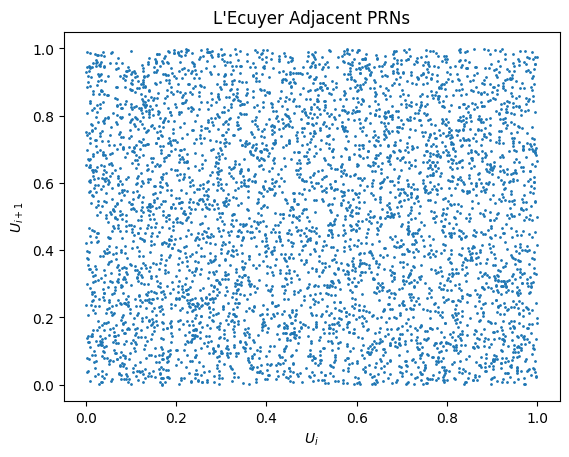

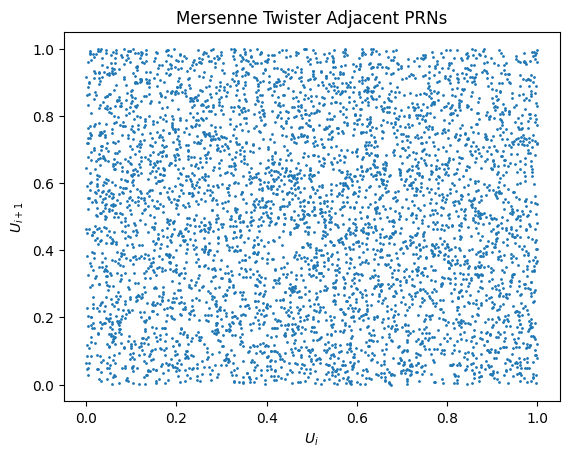

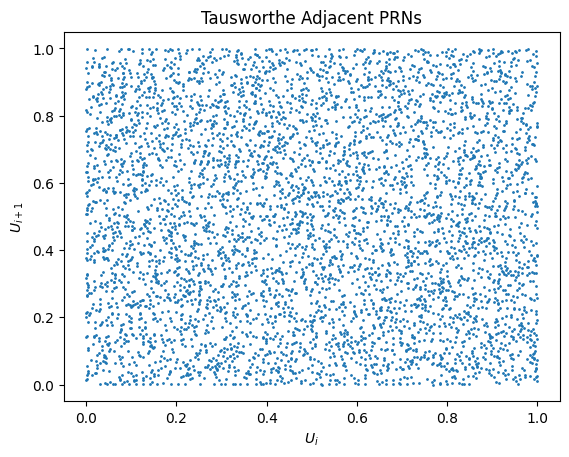

In [4]:
# L'Ecuyer 
x = samples[:-1,COL_LECUYER]
y = samples[1:,COL_LECUYER]
plt.scatter(x=x, y=y, s=1)
plt.title('L\'Ecuyer Adjacent PRNs')
plt.xlabel('$U_i$')
plt.ylabel('$U_{i+1}$')
plt.show()

# Mersenne
x = samples[:-1,COL_MERSENNE]
y = samples[1:,COL_MERSENNE]
plt.scatter(x=x, y=y, s=1)
plt.title('Mersenne Twister Adjacent PRNs')
plt.xlabel('$U_i$')
plt.ylabel('$U_{i+1}$')
plt.show()

# Tausworthe
x = samples[:-1,COL_TAUSWORTHE]
y = samples[1:,COL_TAUSWORTHE]
plt.scatter(x=x, y=y, s=1)
plt.title('Tausworthe Adjacent PRNs')
plt.xlabel('$U_i$')
plt.ylabel('$U_{i+1}$')
plt.show()

The unit square plots for each generator show no discernable pattern.

## Unit Cube Plots

In [5]:
def plot_unit_cube(col, title):
  x = samples[:-2, col]
  y = samples[1:-1, col]
  z = samples[2:, col]

  # 3D plot
  fig = plt.figure(figsize=(10, 8))
  ax = fig.add_subplot(221,projection='3d')
  ax.scatter(x, y, z, s=1)

  # 2D plots
  plt.subplot(2,2,2)
  plt.scatter(x=x, y=y, s=1)
  plt.xlabel('$U_i$')
  plt.ylabel('$U_{i+1}$')

  plt.subplot(2,2,3)
  plt.scatter(x=x, y=z, s=1)
  plt.xlabel('$U_i$')
  plt.ylabel('$U_{i+2}$')

  plt.subplot(2,2,4)
  plt.scatter(x=y, y=z, s=1)
  plt.xlabel('$U_{i+1}$')
  plt.ylabel('$U_{i+2}$')

  fig.suptitle(title)
  plt.show()

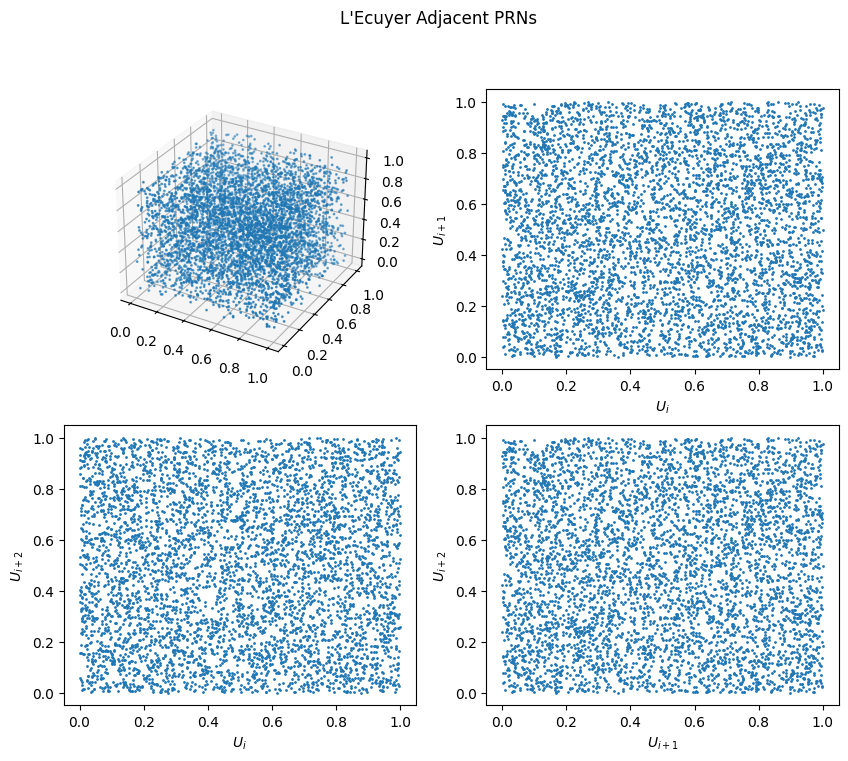

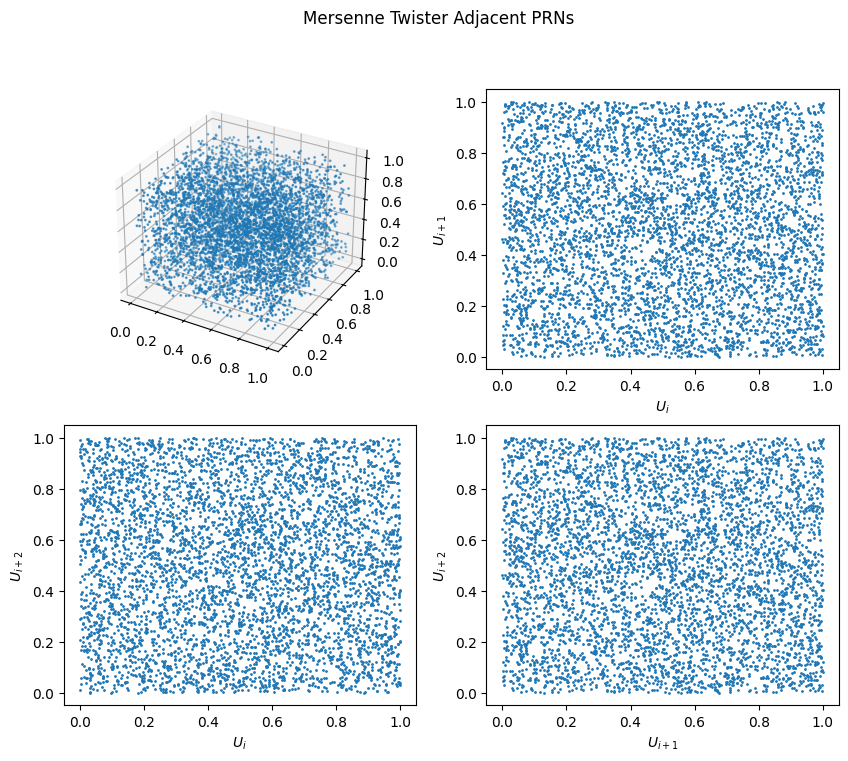

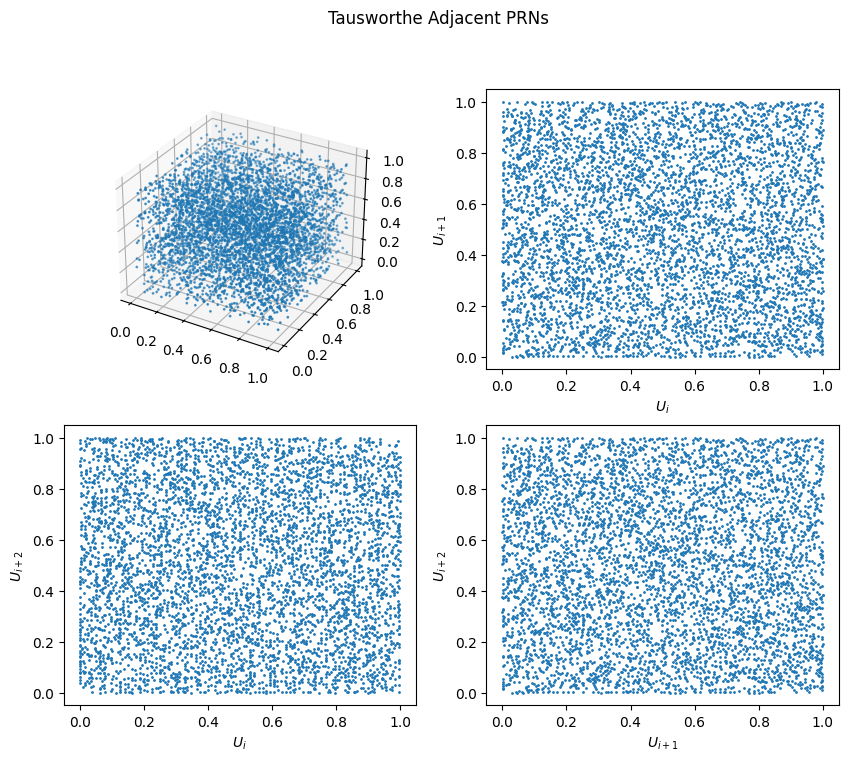

In [6]:
plot_unit_cube(COL_LECUYER, 'L\'Ecuyer Adjacent PRNs')
plot_unit_cube(COL_MERSENNE, 'Mersenne Twister Adjacent PRNs')
plot_unit_cube(COL_TAUSWORTHE, 'Tausworthe Adjacent PRNs')

The unit cube plots show no discernable patterns in any dimension.

## Goodness of Fit

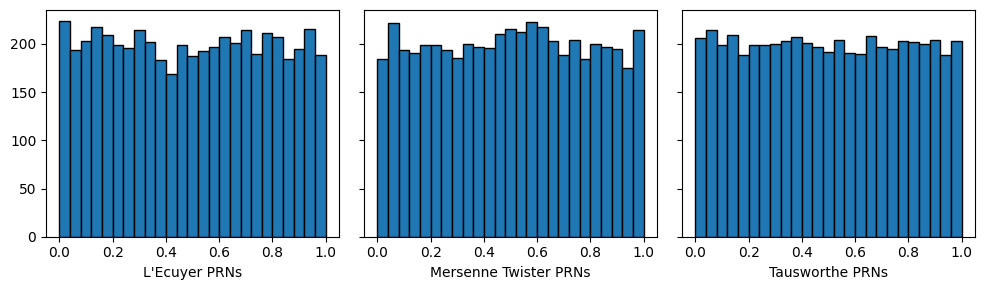

In [7]:
x_lecuyer = samples[:, COL_LECUYER]
x_mersenne = samples[:, COL_MERSENNE]
x_tausworthe = samples[:, COL_TAUSWORTHE]


fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=False, figsize=(10,3))

axs[0].hist(x_lecuyer, bins=25, edgecolor='black')
axs[0].set_xlabel('L\'Ecuyer PRNs')

axs[1].hist(x_mersenne, bins=25, edgecolor='black')
axs[1].set_xlabel('Mersenne Twister PRNs')

axs[2].hist(x_tausworthe, bins=25, edgecolor='black')
axs[2].set_xlabel('Tausworthe PRNs')

plt.show()

Histograms show decent shape.

In [8]:
def calculate_chisq(data, n_bins):
  E = [len(data) / n_bins] * n_bins
  O = [0] * n_bins

  for obs in data:
    i = floor(obs * n_bins)
    if i == n_bins: i -= 1
    O[i] += 1

  return sum([(O[i] - E[i])**2 / E[i] for i in range(n_bins)])

In [9]:
n_bins = 25
chisq_lecuyer = calculate_chisq(x_lecuyer, n_bins)
chisq_mersenne = calculate_chisq(x_mersenne, n_bins)
chisq_tausworthe = calculate_chisq(x_tausworthe, n_bins)

alpha = 0.05
crit = chi2.ppf(1-alpha, n_bins-1)

pval_lecuyer = 1-chi2.cdf(chisq_lecuyer, n_bins-1)
pval_mersenne = 1-chi2.cdf(chisq_mersenne, n_bins-1)
pval_tausworthe = 1-chi2.cdf(chisq_tausworthe, n_bins-1)

pd.DataFrame({
  'RNG' : ['L\'Ecuyer', 'Mersenne Twister', 'Tausworthe'],
  'Chi-square Statistic': [chisq_lecuyer, chisq_mersenne, chisq_tausworthe],
  'Critical Value': [crit] * 3,
  'p-value': [pval_lecuyer, pval_mersenne, pval_tausworthe],
  'Reject': [chisq_lecuyer > crit, chisq_mersenne > crit, chisq_tausworthe > crit]
})

,RNG,Chi-square Statistic,Critical Value,p-value,Reject
0,L'Ecuyer,18.01,36.415029,0.802523,False
1,Mersenne Twister,18.68,36.415029,0.768833,False
2,Tausworthe,4.97,36.415029,0.999988,False


Fail to reject $H_0$ and conclude good fit.

In [10]:
# Alternate test using statsmodels package

def calculate_chisq2(data, n_bins):
  E = [len(data) / n_bins] * n_bins
  O = [0] * n_bins

  for obs in data:
    i = floor(obs * n_bins)
    if i == n_bins: i -= 1
    O[i] += 1

  return sm.stats.gof.powerdiscrepancy(O, E, lambd=1)

In [11]:
gof_lecuyer = calculate_chisq2(x_lecuyer, n_bins)
gof_mersenne = calculate_chisq2(x_mersenne, n_bins)
gof_tausworthe = calculate_chisq2(x_tausworthe, n_bins)

pd.DataFrame({
  'RNG' : ['L\'Ecuyer', 'Mersenne Twister', 'Tausworthe'],
  'Chi-square Statistic': [gof_lecuyer[0], gof_mersenne[0], gof_mersenne[0]],
  'p-value': [gof_lecuyer[1], gof_lecuyer[1], gof_tausworthe[1]],
})

,RNG,Chi-square Statistic,p-value
0,L'Ecuyer,18.01,0.802523
1,Mersenne Twister,18.68,0.802523
2,Tausworthe,18.68,0.999988


Same results from statsmodels test.

In [12]:
ks_lecuyer = kstest(x_lecuyer, uniform.cdf, (0, 1))
ks_mersenne = kstest(x_mersenne, uniform.cdf, (0, 1))
ks_tausworthe = kstest(x_tausworthe, uniform.cdf, (0, 1))

print(ks_lecuyer)
print(ks_mersenne)
print(ks_tausworthe)

KstestResult(statistic=np.float64(0.013976515745905194), pvalue=np.float64(0.28016633013657055), statistic_location=np.float64(0.3368234842540948), statistic_sign=np.int8(1))
KstestResult(statistic=np.float64(0.010424446273693988), pvalue=np.float64(0.6449273869895829), statistic_location=np.float64(0.658775553726306), statistic_sign=np.int8(1))
KstestResult(statistic=np.float64(0.006778178604692209), pvalue=np.float64(0.9745011267864127), statistic_location=np.float64(0.4298218213953078), statistic_sign=np.int8(1))


Same results from Kolmogorov-Smirnov.

### Independence

In [22]:
def updown_runs_test(data):
  run_list = []
  for i in range(1, len(data)):
    run_list.append(data[i] > data[i-1])

  
  A = len([a for a, _ in itertools.groupby(run_list)])
  mu = 2*len(data)/3
  var = 16*len(data)/90
  sd = sqrt(var)
  Z0 = (A-mu) / sd

  alpha = 0.05
  crit = norm.ppf(1-(alpha/2), loc=0, scale=1)

  p = 2*(1-norm.cdf(abs(A), loc=0, scale=1))

  return A, mu, var, Z0, crit, p, abs(Z0) > crit

In [21]:
updown_runs_lecuyer = updown_runs_test(x_lecuyer)
updown_runs_mersenne = updown_runs_test(x_mersenne)
updown_runs_tausworthe = updown_runs_test(x_tausworthe)

testresults = pd.DataFrame([updown_runs_lecuyer, updown_runs_mersenne, updown_runs_tausworthe], 
                           columns=['# Runs', 'E[# Runs]', 'Var(# Runs)', '|Z Statistic|', 'Critical Value', 'p-value', 'Reject'])
testresults.insert(loc=0, column='RNG', value=['L\'Ecuyer', 'Mersenne Twister', 'Tausworthe'])
testresults

,RNG,# Runs,E[# Runs],Var(# Runs),|Z Statistic|,Critical Value,p-value,Reject
0,L'Ecuyer,3323,3333.333333,888.888889,-0.346591,1.959964,0.0,False
1,Mersenne Twister,3323,3333.333333,888.888889,-0.346591,1.959964,0.0,False
2,Tausworthe,3338,3333.333333,888.888889,0.156525,1.959964,0.0,False
